
# Is it possible to build a classifier to identify legendary pokémon?

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd

pokemon = pd.read_csv("../dataset/pokemon.csv")
pokemon.set_index('name',inplace=True)
pokemon.head()

,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,percentage_male,pokedex_number,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary
name,,,,,,,,,,,,,,,,,,,,,
Bulbasaur,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,1,65,65,45,grass,poison,6.9,1,0
Ivysaur,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,2,80,80,60,grass,poison,13.0,1,0
Venusaur,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,3,122,120,80,grass,poison,100.0,1,0
Charmander,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,4,60,50,65,fire,NaN,8.5,1,0
Charmeleon,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,5,80,65,80,fire,NaN,19.0,1,0


We will proceed by building a <b> decision tree </b> considering various feature such as the capture_rate, the stats and the types.

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score

import numpy as np

In [3]:
X = pokemon
y = np.array(pokemon['is_legendary'])

In [4]:
def train(model_class, X, y, num_fold_cross_val, scaling=StandardScaler(), dim_reduction=None):
        
    X_std = scaling.fit_transform(X)  if scaling is not None else X
    
    X_std = dim_reduction.fit_transform(X_std) if dim_reduction is not None else X_std

    val = cross_val_score(model_class(), X_std, y, cv=num_fold_cross_val)
        
    return val.mean()

In [3]:
### Step 0 : capture_rate

In [5]:
features0 = ['capture_rate']
X0 = X.filter(features0)

In [6]:
train(tree.DecisionTreeClassifier,X0.values,y,7)

0.9712106352838619

In [4]:
### Step 1: base_total, capture_rate

In [7]:
features1 = ['base_total','capture_rate']

In [8]:
X1 = X.filter(features1)
X1.head()

,base_total,capture_rate
name,,
Bulbasaur,318,45
Ivysaur,405,45
Venusaur,625,45
Charmander,309,45
Charmeleon,405,45


In [9]:
train(tree.DecisionTreeClassifier,X1.values,y,7,dim_reduction=PCA(n_components=2))

0.9674948240165632

In [5]:
### Step 2 : stats, capture_rate

In [10]:
features2 = ['capture_rate','attack','defense','speed','sp_attack','sp_defense','hp']
X2 = X.filter(features2)

In [11]:
train(tree.DecisionTreeClassifier,X2.values,y,7,dim_reduction=PCA(n_components=6))

0.9413206930369401

In [6]:
### Step 3: gender, capture_rate

In [12]:
import math

To use percentage_male column we have to transform nan values into value outside the domain [0:100] (e.g. -1)

In [13]:
features3 = ['percentage_male','capture_rate']
X3 = X.filter(features3)
X3['percentage_male'] = list(map(lambda x: -1 if math.isnan(x) else x, X3['percentage_male'].values))
X3.tail()

,percentage_male,capture_rate
name,,
Celesteela,-1.0,25
Kartana,-1.0,255
Guzzlord,-1.0,15
Necrozma,-1.0,3
Magearna,-1.0,3


In [14]:
train(tree.DecisionTreeClassifier,X3.values,y,7,dim_reduction=PCA(n_components=2))

0.9749809305873379

In [15]:
tree3 = tree.DecisionTreeClassifier()
tree3.fit(PCA(n_components=2).fit_transform(StandardScaler().fit_transform(X3.values)),y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [16]:
predicts = tree3.predict(PCA(n_components=2).fit_transform(StandardScaler().fit_transform(X3.values)))

Let's see who are the FP and FN pokemon

In [17]:
X_legendary = X[['is_legendary']]
X_legendary['predict'] = predicts
X_legendary[X_legendary['is_legendary']!=X_legendary['predict']]

,is_legendary,predict
name,,
Porygon,0,1
Porygon2,0,1
Shedinja,0,1
Lunatone,0,1
Solrock,0,1
Beldum,0,1
Metang,0,1
Metagross,0,1
Rotom,0,1


#### Data visualization

In [29]:
import matplotlib.pyplot as plt

In [32]:
def gr_dataset(df): 
    for lab, col in zip((0, 1),
                        ('black', 'gold')):
        plt.scatter(df.values[y==lab, 0],
                    df.values[y==lab, 1],
                    label=lab,
                    c=col)

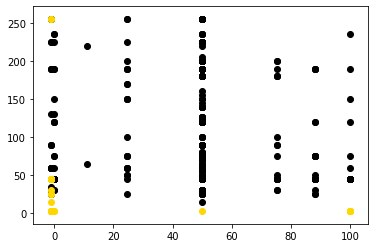

In [33]:
gr_dataset(X3)

### Step 4 : gender,capture_rate, type1, type2

In [18]:
features4 = ['percentage_male','capture_rate','type1','type2']
X4 = X.filter(features4)
X4['percentage_male'] = list(map(lambda x: -1 if math.isnan(x) else x, X4['percentage_male'].values))

In order to use the type1 column, it is necessary to encode the type labels into numbers.

It is also necessary to convert the nan labels of the type2 column to the empty type "" and then encode they too.

In [19]:
from sklearn import preprocessing

le1 = preprocessing.LabelEncoder()
le1.fit(X4['type1'].values)
X4['type1']= le1.transform(X4['type1'].values)

X4['type2'] = list(map(lambda x: "" if isinstance(x,float) and math.isnan(x) else x, X4['type2'].values))
le2 = preprocessing.LabelEncoder()
le2.fit(X4['type2'].values)
X4['type2'] = le2.transform(X4['type2'].values)

X4.tail()

,percentage_male,capture_rate,type1,type2
name,,,,
Celesteela,-1.0,25,16,8
Kartana,-1.0,255,9,17
Guzzlord,-1.0,15,1,3
Necrozma,-1.0,3,14,0
Magearna,-1.0,3,16,5


In [20]:
train(tree.DecisionTreeClassifier,X4.values,y,7,dim_reduction=PCA(n_components=4))

0.9574806581671569

### Step 5 : gender, capture_rate, base_egg_steps

In [21]:
features5 = ['percentage_male','capture_rate','base_egg_steps']
X5 = X.filter(features5)
X5['percentage_male'] = list(map(lambda x: -1 if math.isnan(x) else x, X5['percentage_male'].values))
X5.tail()

,percentage_male,capture_rate,base_egg_steps
name,,,
Celesteela,-1.0,25,30720
Kartana,-1.0,255,30720
Guzzlord,-1.0,15,30720
Necrozma,-1.0,3,30720
Magearna,-1.0,3,30720


In [22]:
train(tree.DecisionTreeClassifier,X5.values,y,7,dim_reduction=PCA(n_components=3))

0.9887327013185135

In [23]:
tree5 = tree.DecisionTreeClassifier()
tree5.fit(PCA(n_components=3).fit_transform(StandardScaler().fit_transform(X5.values)),y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [24]:
predicts = tree5.predict(PCA(n_components=3).fit_transform(StandardScaler().fit_transform(X5.values)))
X_legendary5 = X[['is_legendary']]
X_legendary5['predict'] = predicts
X_legendary5[X_legendary5['is_legendary']!=X_legendary5['predict']]

,is_legendary,predict
name,,
Type: Null,0,1
Silvally,0,1


# DEMO

In [25]:
def is_legendary(pokemon):
    df = pd.read_csv("../dataset/pokemon.csv")
    df.set_index('name',inplace=True)
    
    X = df
    y = np.array(df['is_legendary'])
    
    features = ['percentage_male','capture_rate','base_egg_steps']
    X_f = X.filter(features)
    X_f['percentage_male'] = list(map(lambda x: -1 if math.isnan(x) else x, X_f['percentage_male'].values))
    
    data = PCA(n_components=3).fit_transform(StandardScaler().fit_transform(X_f.values))
    df_totrain = pd.DataFrame(data,columns=features,index=X_f.index)
    clf = tree.DecisionTreeClassifier()
    clf.fit(data,y)
    
    return clf.predict(np.asarray([df_totrain.loc[pokemon].values]))

In [26]:
pokemon = input()
print("legendary") if is_legendary(pokemon) else print("no-legendary")

Finneon
no-legendary
